# Images external to jupyter: %matplotlib notebook

In [1]:
from diffractio import degrees, um
from diffractio import np, plt

from diffractio.utils_multiprocessing import execute_multiprocessing

from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_masks_XZ import Scalar_mask_XZ
from diffractio import num_max_processors

## image in an external window

In [2]:
x0 = np.linspace(-200 * um, 200 * um, 512)
z0 = np.linspace(-100 * um, 600 * um, 512 * 4)
wavelength = 10 * um
u0 = Scalar_source_X(x=x0, wavelength=wavelength)
u0.plane_wave(A=1, theta=0 * degrees)
u1 = Scalar_mask_XZ(x=x0, z=z0, wavelength=wavelength)
u1.incident_field(u0)
focal, _ = u1.lens(
    r0=(0 * um, 0 * um),
    size=300 * um,
    radii=(1000 * um, -250 * um),
    thickness=100 * um,
    refractive_index=2,
    angle=0 * degrees,
    mask=(10 * um, 3 + 5j),
)


u1.surface_detection()

208.33333333333331


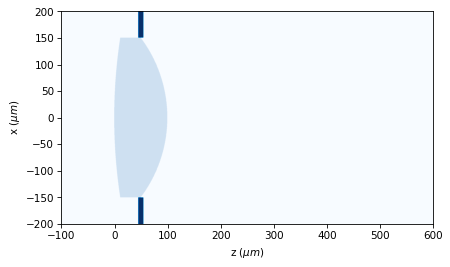

In [3]:
print(focal)
u1.draw_refractive_index(scale="scaled")
edge_matrix = u1.borders

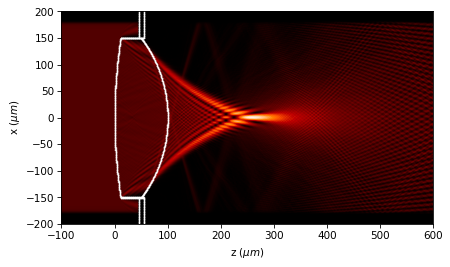

In [4]:
u1.BPM(verbose=False)
u1.draw(logarithm=True, normalize="maximum", draw_borders=True, scale="scaled")

### simulation of a video

In [5]:
def __experiment_grating_movement__(dict_params):
    delta_x = dict_params["delta_x"]
    period = dict_params["period"]
    t1 = dict_params["t1"]
    t2 = dict_params["t2"]
    t2.ronchi_grating(period=period, x0=delta_x, fill_factor=0.5)
    u2 = t1 * t2
    return u2

In [6]:
def creation_dictionary(deltas_x, period, t1, t2):
    # create Parameters: for multiprocessing
    dict_Parameters = []
    for i, delta_x in enumerate(deltas_x):
        dict_Parameters.append(dict(delta_x=delta_x, period=period, t1=t1, t2=t2))
    return dict_Parameters

In [7]:
x0 = np.linspace(-400 * um, 400 * um, 1024 * 4)
wavelength = 0.85 * um
period = 50 * um
z_talbot = 2 * period**2 / wavelength
z0 = z_talbot / 2
delay = 0.001

t1 = Scalar_mask_X(x0, wavelength, info="__experiment_grating_movement__")
t1.ronchi_grating(period=period, x0=0 * um, fill_factor=0.5)
t1.RS(z=z0, new_field=False)

t2 = Scalar_mask_X(x0, wavelength, info="__experiment_grating_movement__")
t2.ronchi_grating(period=period, x0=0 * um, fill_factor=0.5)

deltas_x = np.linspace(-60 * um, 60 * um, 128)  # 512

dict_Parameters = creation_dictionary(deltas_x=deltas_x, period=period, t1=t1, t2=t2)

u_s, time_proc = execute_multiprocessing(
    __experiment_grating_movement__, dict_Parameters, num_processors=1, verbose=True
)

x = u_s[0].x

Good result: factor 16.02
num_proc: 1, time=0.007066011428833008


In [8]:
%matplotlib qt5


In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

perfil = np.zeros_like(deltas_x)

(h1,) = ax1.plot(x, np.zeros_like(x), "k", lw=2)
ax1.set_xlim(x[0], x[-1])
ax1.set_ylim(0, 2)
ax1.set_xlabel(r"$x (\mu m)$")

(h2,) = ax2.plot(deltas_x, perfil, "k", lw=2)
ax2.set_xlim(deltas_x[0], deltas_x[-1])
ax2.set_ylim(0, 0.5)
ax2.set_xlabel(r"$\Delta x (\mu m)$")

incr_frames = 1
for i in range(0, len(deltas_x), incr_frames):
    intensidad = abs(u_s[i].u) ** 2  # sacar fuera
    perfil[i] = intensidad.mean()
    plt.suptitle(r"$\delta x={:6.2f}\,\mu m$".format(deltas_x[i]), fontsize=18)
    h1.set_ydata(intensidad)
    h2.set_ydata(perfil)
    plt.draw()
    plt.pause(0.005)

plt.close()

<img src="qt_propagation.png" width="400">

In [10]:
%matplotlib inline
